In [3]:
import pandas as pd

In [4]:
file_path = '/content/Online Retail.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

In [5]:
print(data.head())

print(data.isnull().sum())

  ï»¿InvoiceNo StockCode                          Description  Quantity  \
0       536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1       536365     71053                  WHITE METAL LANTERN         6   
2       536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3       536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4       536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01/12/2010 08:26       2.55     17850.0  United Kingdom  
1  01/12/2010 08:26       3.39     17850.0  United Kingdom  
2  01/12/2010 08:26       2.75     17850.0  United Kingdom  
3  01/12/2010 08:26       3.39     17850.0  United Kingdom  
4  01/12/2010 08:26       3.39     17850.0  United Kingdom  
ï»¿InvoiceNo         0
StockCode            0
Description       1454
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      135080
Country              0

In [6]:
# Convert InvoiceDate to datetime format with error handling
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')

# Check for any rows with NaT values in the InvoiceDate column
invalid_dates = data[data['InvoiceDate'].isna()]
print(f"Number of invalid dates: {len(invalid_dates)}")

# Display rows with invalid dates if any exist
if len(invalid_dates) > 0:
    print(invalid_dates)


Number of invalid dates: 308950
       ï»¿InvoiceNo StockCode                          Description  Quantity  \
26732        538521     21754             HOME BUILDING BLOCK WORD         3   
26733        538521     21755             LOVE BUILDING BLOCK WORD         3   
26734        538521     22072    RED RETROSPOT TEA CUP AND SAUCER          8   
26735        538521     22846           BREAD BIN DINER STYLE RED          1   
26736        538521     22849           BREAD BIN DINER STYLE MINT         1   
...             ...       ...                                  ...       ...   
516379      C579886     22197                       POPCORN HOLDER        -1   
516380      C579886     23146       TRIPLE HOOK ANTIQUE IVORY ROSE        -1   
516381      C579887     84946         ANTIQUE SILVER T-LIGHT GLASS        -1   
516382      C579887     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        -1   
516383      C579887     23490     T-LIGHT HOLDER HANGING LOVE BIRD        -3   

       

In [7]:
# Remove rows with missing CustomerID
data = data.dropna(subset=['CustomerID'])

# Remove canceled orders (negative quantity)
data = data[data['Quantity'] > 0]

# Create TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Check the cleaned data
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ï»¿InvoiceNo  397924 non-null  object        
 1   StockCode     397924 non-null  object        
 2   Description   397924 non-null  object        
 3   Quantity      397924 non-null  int64         
 4   InvoiceDate   168649 non-null  datetime64[ns]
 5   UnitPrice     397924 non-null  float64       
 6   CustomerID    397924 non-null  float64       
 7   Country       397924 non-null  object        
 8   TotalPrice    397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB
None
  ï»¿InvoiceNo StockCode                          Description  Quantity  \
0       536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1       536365     71053                  WHITE METAL LANTERN         6   
2       536365    8440

In [8]:
print(data.columns)

Index(['ï»¿InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice'],
      dtype='object')


In [9]:
from datetime import datetime

# Set the reference date to one day after the last transaction in the dataset
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate Recency, Frequency, and Monetary metrics
rfm = data.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
    Frequency=('ï»¿InvoiceNo', 'nunique'),
    Monetary=('TotalPrice', 'sum')
).reset_index()

# Display the RFM DataFrame
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0     12346.0      NaN          1  77183.60
1     12347.0     96.0          7   4310.00
2     12348.0    221.0          4   1797.24
3     12349.0      NaN          1   1757.55
4     12350.0    312.0          1    334.40


In [10]:
# Define a function to assign scores based on quantiles
def rfm_score(df, column):
    return pd.qcut(df[column], 5, labels=[5, 4, 3, 2, 1])

# Assign RFM scores
rfm['Recency_Score'] = rfm['Recency'].apply(lambda x: 5 if x <= rfm['Recency'].quantile(0.2) else
                                             4 if x <= rfm['Recency'].quantile(0.4) else
                                             3 if x <= rfm['Recency'].quantile(0.6) else
                                             2 if x <= rfm['Recency'].quantile(0.8) else 1)

rfm['Frequency_Score'] = rfm['Frequency'].apply(lambda x: 5 if x >= rfm['Frequency'].quantile(0.8) else
                                               4 if x >= rfm['Frequency'].quantile(0.6) else
                                               3 if x >= rfm['Frequency'].quantile(0.4) else
                                               2 if x >= rfm['Frequency'].quantile(0.2) else 1)

rfm['Monetary_Score'] = rfm['Monetary'].apply(lambda x: 5 if x >= rfm['Monetary'].quantile(0.8) else
                                              4 if x >= rfm['Monetary'].quantile(0.6) else
                                              3 if x >= rfm['Monetary'].quantile(0.4) else
                                              2 if x >= rfm['Monetary'].quantile(0.2) else 1)

# Combine all the scores
rfm['RFM_Score'] = rfm['Recency_Score'].astype(str) + rfm['Frequency_Score'].astype(str) + rfm['Monetary_Score'].astype(str)

# Display the scored RFM DataFrame
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary  Recency_Score  Frequency_Score  \
0     12346.0      NaN          1  77183.60              1                2   
1     12347.0     96.0          7   4310.00              3                5   
2     12348.0    221.0          4   1797.24              2                4   
3     12349.0      NaN          1   1757.55              1                2   
4     12350.0    312.0          1    334.40              1                2   

   Monetary_Score RFM_Score  
0               5       125  
1               5       355  
2               4       244  
3               4       124  
4               2       122  


In [11]:
# Define segmentation based on the RFM_Score
def segment_customers(row):
    if row['RFM_Score'] == '555':
        return 'High-Value Customer'
    elif row['RFM_Score'].startswith('5'):
        return 'Loyal Customer'
    elif row['RFM_Score'].endswith('1'):
        return 'At-Risk Customer'
    else:
        return 'Regular Customer'

# Apply the segmentation function
rfm['Segment'] = rfm.apply(segment_customers, axis=1)

# Display the segmented customers
print(rfm[['CustomerID', 'RFM_Score', 'Segment']].head())


   CustomerID RFM_Score           Segment
0     12346.0       125  Regular Customer
1     12347.0       355  Regular Customer
2     12348.0       244  Regular Customer
3     12349.0       124  Regular Customer
4     12350.0       122  Regular Customer


<ipython-input-12-94317ad105e6>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', palette='Set2')


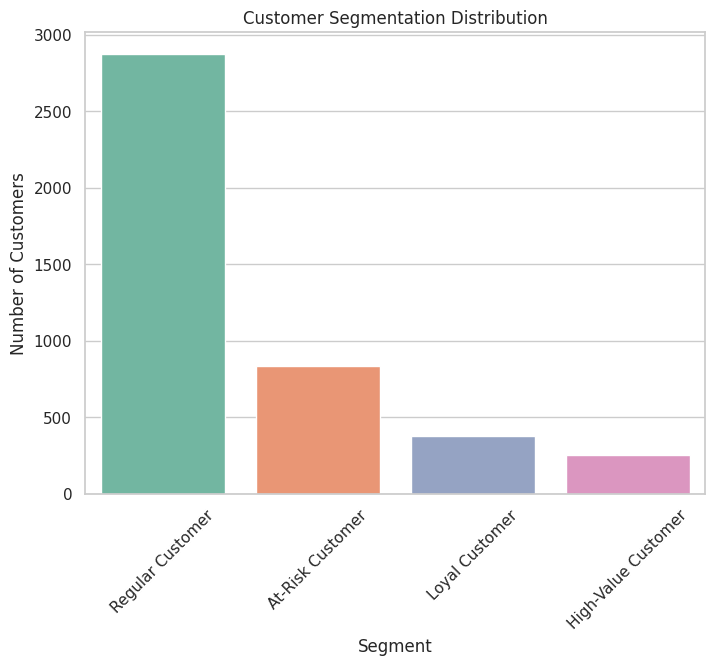

<ipython-input-12-94317ad105e6>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Recency_Score', palette='Blues')
<ipython-input-12-94317ad105e6>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Frequency_Score', palette='Greens')
<ipython-input-12-94317ad105e6>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Monetary_Score', palette='Oranges')


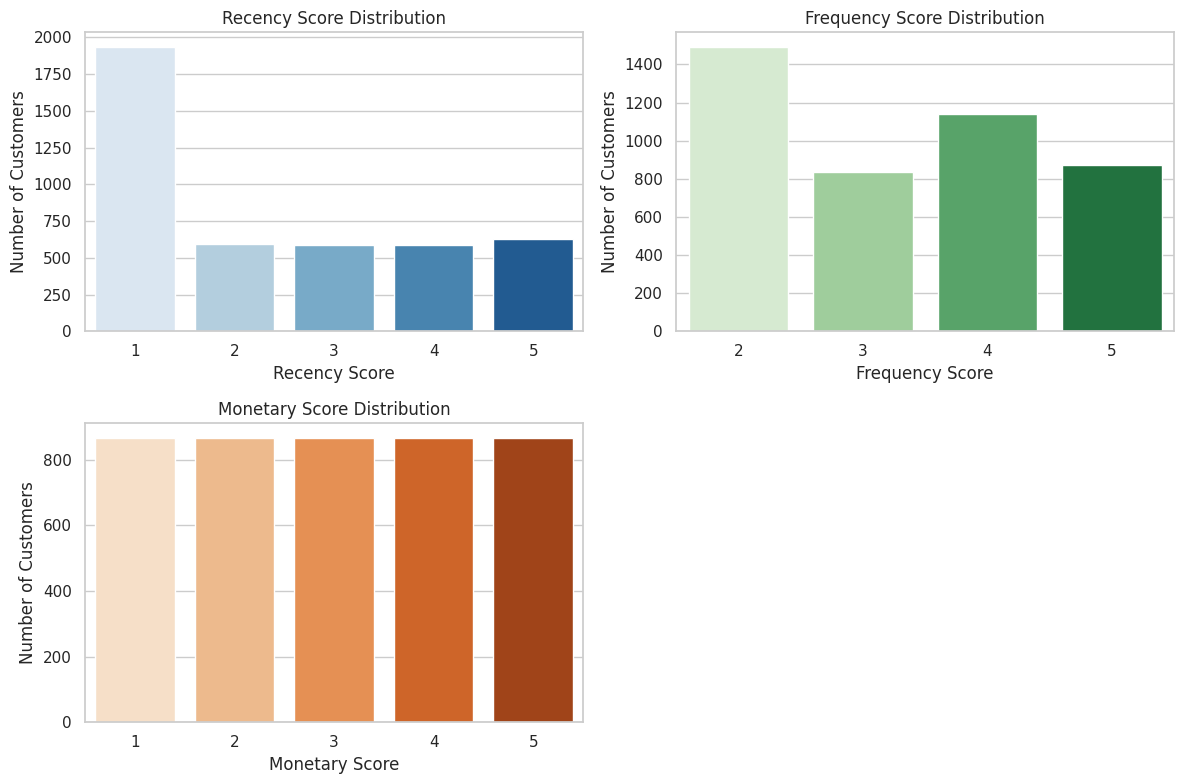

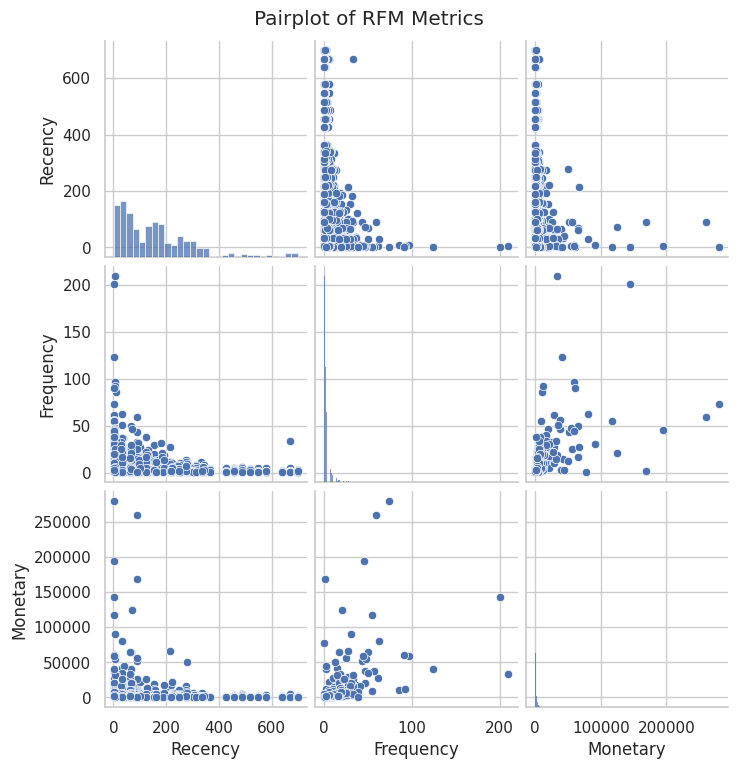

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# 1. Plot the distribution of customers in each segment
plt.figure(figsize=(8, 6))
sns.countplot(data=rfm, x='Segment', palette='Set2')
plt.title('Customer Segmentation Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

# 2. Plot the distribution of RFM scores
plt.figure(figsize=(12, 8))

# Recency score distribution
plt.subplot(2, 2, 1)
sns.countplot(data=rfm, x='Recency_Score', palette='Blues')
plt.title('Recency Score Distribution')
plt.xlabel('Recency Score')
plt.ylabel('Number of Customers')

# Frequency score distribution
plt.subplot(2, 2, 2)
sns.countplot(data=rfm, x='Frequency_Score', palette='Greens')
plt.title('Frequency Score Distribution')
plt.xlabel('Frequency Score')
plt.ylabel('Number of Customers')

# Monetary score distribution
plt.subplot(2, 2, 3)
sns.countplot(data=rfm, x='Monetary_Score', palette='Oranges')
plt.title('Monetary Score Distribution')
plt.xlabel('Monetary Score')
plt.ylabel('Number of Customers')

plt.tight_layout()
plt.show()

# 3. Pairplot to visualize relationships between RFM metrics
sns.pairplot(rfm[['Recency', 'Frequency', 'Monetary']], height=2.5)
plt.suptitle("Pairplot of RFM Metrics", y=1.02)
plt.show()


In [13]:
# Export the RFM DataFrame to a CSV file
rfm.to_csv('rfm_segmented_customers.csv', index=False)
